# Set-Up and Imports

In [28]:
import jax
import jax.numpy as jnp
import numpy as np
import surrojax_gp
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import sys
import json
from arraytainers import Arraytainer
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

Plotting settings:

In [29]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100
# dpi of images saved to seperate folder:
mpl_save_dpi = 300
# Plot theme:
sns.set_theme(style='darkgrid')
palette = sns.color_palette()

Save directory for figures:

In [30]:
fig_save_dir = './figs/ape'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

Random seeds:

In [31]:
jax_rng = jax.random.PRNGKey(42)
np_seed = 42

# Creation of Posteriors

First, let's compare our three posterior approximations to the 'true' posterior:

In [32]:
beam_gp = surrojax_gp.load_gp('../chapter_4/nonlinear_beam_gp.json')

Setting our noise and prior parameters (same as last notebook):

In [33]:
noise_cov = 0.005*jnp.identity(1)
prior_cov = 0.01*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))

Let's load our Amortised distributions:

In [34]:
# From previous notebook:
activation = 'tanh'
num_layers = 5
width = 10
phi_lims = {'mean': {'lb':-0.25, 'ub':1.25}, 'log_chol_diag': {'lb':-3, 'ub':-2.}}
reverse_dist = computation_helpers.load_approx_post('reverse_kl_approx.json', activation, num_layers, width, phi_lims)
forward_dist = computation_helpers.load_approx_post('forward_kl_approx.json', activation, num_layers, width, phi_lims)

For convenience, we'll wrap these distributions using the oed_toolbox package:

In [35]:
reverse_approx = oed_toolbox.distributions.Posterior.from_approx_post(reverse_dist)
forward_approx = oed_toolbox.distributions.Posterior.from_approx_post(forward_dist)

We can use the oed_toolbox to create a local linearisation approximation as well:

In [36]:
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
minimizer = oed_toolbox.optim.gradient_descent_for_map()
laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, noise_cov, prior_mean, prior_cov)

Let's also create a prior and joint distribution:

In [37]:
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
joint = oed_toolbox.distributions.Joint.from_prior_and_likelihood(prior, likelihood)

Finally, we'll create the 'true' posterior by using line intergration:

In [38]:
true_posterior = computation_helpers.construct_true_posterior(beam_model, noise_cov, prior_mean, prior_cov)

# Comparison of Posteriors

Let's first compare all of our posteriors to the 'true' one. We only really care about how well our posteriors do on samples from the joint (since that's how the APE is computed). Consequently, let's draw a sample from the joint distributtion and plot each distribution for 6 different $d$ values:

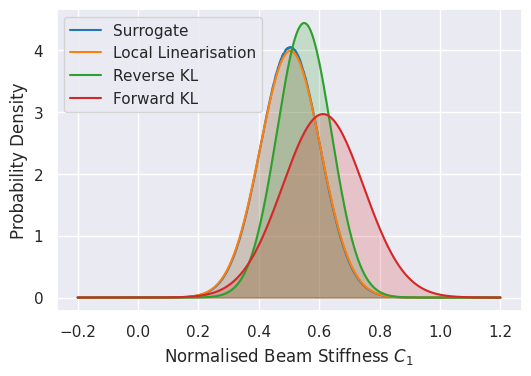

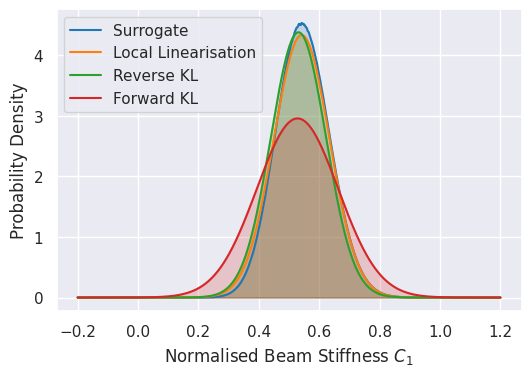

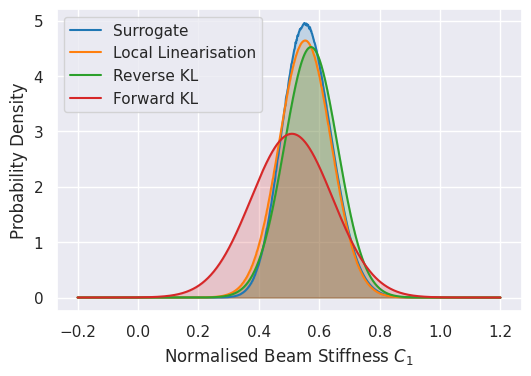

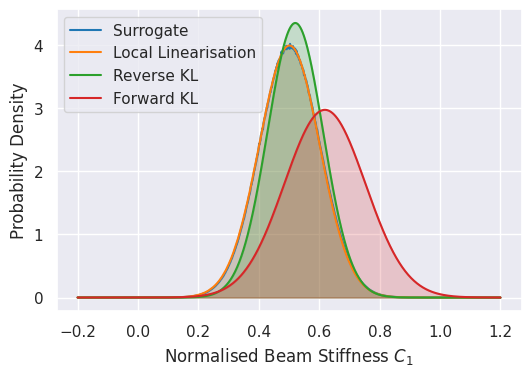

In [40]:
d_vals = np.linspace(0,1,4).reshape(-1,1)
theta_plot = jnp.linspace(-0.2, 1.2, 1000).reshape(-1,1)
for d in d_vals:
    y = joint.sample(d, num_samples=1, rng=np.random.default_rng(np_seed))['y']
    pdfs = {'Surrogate': true_posterior(theta_plot, y, d), 
            'Local Linearisation': jnp.exp(laplace_approx.logpdf(theta_plot, y, d)['logpdf']),
            'Reverse KL': jnp.exp(reverse_approx.logpdf(theta_plot, y, d)['logpdf']),
            'Forward KL': jnp.exp(forward_approx.logpdf(theta_plot, y, d)['logpdf'])}
    plotting_helpers.plot_distributions(pdfs, theta_plot, xlabel='Normalised Beam Stiffness $C_1$', legend_loc='upper left')
    plt.savefig(os.path.join(fig_save_dir, f'post_comp_d={d.item():.1f}_y={y.item():.4f}.png'), dpi=mpl_save_dpi)

To more quantitatively evaluate the 'fit' of each posterior, let's compute the $y$-averaged Forward and Reverse KL divergence between each posterior and the true posterior for different values of $d$:

In [19]:
d_vals = np.linspace(0,1,10).reshape(-1,1)
theta_compute = jnp.linspace(-0.5, 1.5, 1000).reshape(-1,1)
d_theta = theta_compute[1] - theta_compute[0]
num_y_samples = 100
y_avg_forward_kl = {'Local Linearisation': [], 'Forward KL': [], 'Reverse KL': []}
y_avg_reverse_kl = {'Local Linearisation': [], 'Forward KL': [], 'Reverse KL': []}
t_very_start = time.time()
for d in d_vals:
    print(f'Now computing y-aved KLs for d = {d.item():.1f}...')
    t_start = time.time()
    true_logpdf, laplace_logpdf, reverse_logpdf, forward_logpdf = [], [], [], []
    y_samples = joint.sample(d, num_samples=num_y_samples, rng=np.random.default_rng(np_seed))['y']
    d = d.reshape(-1,1)
    for y in y_samples:
        y = y.reshape(-1,1)
        # Ensure pdf isn't too small or log returns NaN:
        true_pdf = np.clip(true_posterior(theta_compute, y, d), a_min=1e-30, a_max=None)
        true_logpdf.append(jnp.log(true_pdf))
        laplace_logpdf.append(laplace_approx.logpdf(theta_compute, y, d)['logpdf'])
        reverse_logpdf.append(reverse_approx.logpdf(theta_compute, y, d)['logpdf'])
        forward_logpdf.append(forward_approx.logpdf(theta_compute, y, d)['logpdf']) 
    y_avg_forward_kl['Local Linearisation'].append(computation_helpers.y_avged_kl(laplace_logpdf, true_logpdf, d_theta, kind='forward'))
    y_avg_forward_kl['Forward KL'].append(computation_helpers.y_avged_kl(forward_logpdf, true_logpdf, d_theta, kind='forward'))
    y_avg_forward_kl['Reverse KL'].append(computation_helpers.y_avged_kl(reverse_logpdf, true_logpdf, d_theta, kind='forward'))
    y_avg_reverse_kl['Local Linearisation'].append(computation_helpers.y_avged_kl(laplace_logpdf, true_logpdf, d_theta, kind='reverse'))
    y_avg_reverse_kl['Forward KL'].append(computation_helpers.y_avged_kl(forward_logpdf, true_logpdf, d_theta, kind='reverse'))
    y_avg_reverse_kl['Reverse KL'].append(computation_helpers.y_avged_kl(reverse_logpdf, true_logpdf, d_theta, kind='reverse'))
    t_compute = time.time() - t_start
    print(f'Took {t_compute:.2f} seconds.')
   
t_overall_compute = time.time() - t_very_start
print(f'All KL calculations took {t_overall_compute:.2f} seconds overall.')

with open('y_avged_forward_kl.json', 'w') as f:
    json.dump(Arraytainer(y_avg_forward_kl).tolist(), f, indent=4)
with open('y_avged_reverse_kl.json', 'w') as f:
    json.dump(Arraytainer(y_avg_reverse_kl).tolist(), f, indent=4)

Now computing y-aved KLs for d = 0.0...
Took 76.23 seconds.
Now computing y-aved KLs for d = 0.1...
Took 78.83 seconds.
Now computing y-aved KLs for d = 0.2...
Took 85.46 seconds.
Now computing y-aved KLs for d = 0.3...
Took 79.61 seconds.
Now computing y-aved KLs for d = 0.4...
Took 84.06 seconds.
Now computing y-aved KLs for d = 0.6...
Took 78.71 seconds.
Now computing y-aved KLs for d = 0.7...
Took 73.12 seconds.
Now computing y-aved KLs for d = 0.8...
Took 73.29 seconds.
Now computing y-aved KLs for d = 0.9...
Took 80.09 seconds.
Now computing y-aved KLs for d = 1.0...
Took 79.04 seconds.
All KL calculations took 788.44 seconds overall.


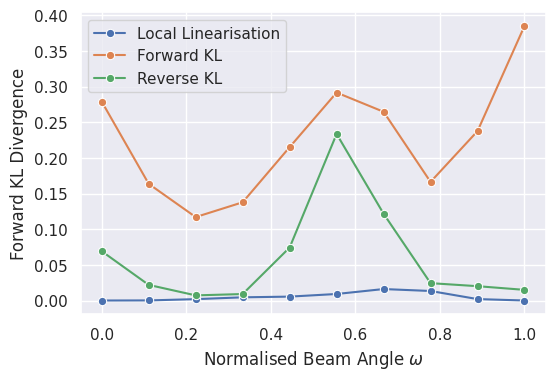

In [14]:
d_vals = np.linspace(0,1,10).reshape(-1,1)
with open('y_avged_forward_kl.json', 'r') as f:
    y_avg_forward_kl = json.load(f)
fig, ax = plt.subplots()
for i, (key, kl) in enumerate(y_avg_forward_kl.items()):
    sns.lineplot(x=np.array(d_vals).squeeze(), y=np.array(kl).squeeze(), color=palette[i], label=key, marker='o')
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Forward KL Divergence')
plt.savefig(os.path.join(fig_save_dir, 'yavg_forward_kl_performance.png'), dpi=mpl_save_dpi)

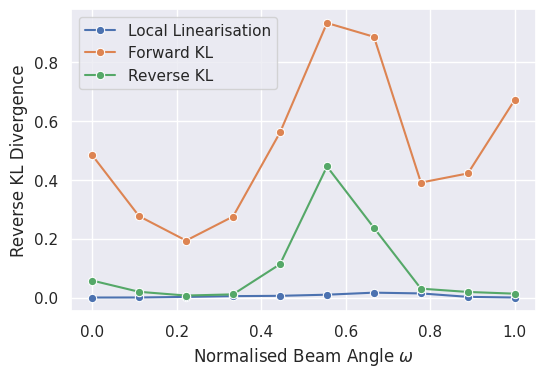

In [15]:
d_vals = np.linspace(0,1,10).reshape(-1,1)
with open('y_avged_reverse_kl.json', 'r') as f:
    y_avg_reverse_kl = json.load(f)
fig, ax = plt.subplots()
for i, (key, kl) in enumerate(y_avg_reverse_kl.items()):
    sns.lineplot(x=np.array(d_vals).squeeze(), y=np.array(kl).squeeze(), color=palette[i], label=key, marker='o')
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Reverse KL Divergence')
plt.savefig(os.path.join(fig_save_dir, 'yavg_reverse_kl_performance.png'), dpi=mpl_save_dpi)

It's clear from the above plots that the Forward-KL approximation is very poor, whereas the Reverse KL approximation is much better. The Local Linearisation approximation is basically perfect.

# Caution about Local Linearisation

Although the above diagnostics show that the local linearisation posterior performs very well, it's important to note that it's implementation assumes that theta value is close to MAP, allowing us to use gradient descent. If this isn't true, then spurious MAP values are found, leading to incorrect pdf predictions:

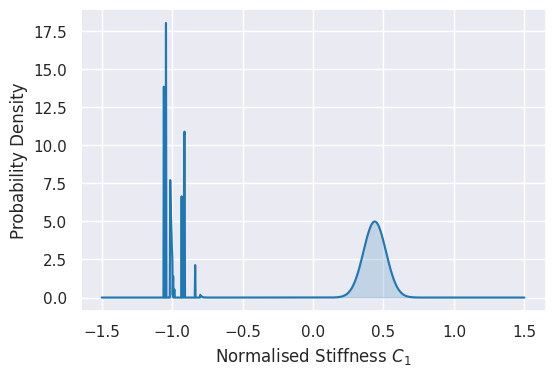

In [16]:
theta_plot = jnp.linspace(-1.5, 1.5, 1000).reshape(-1,1)
y = 0.5
d = 0.5
logpdfs = laplace_approx.logpdf(theta_plot, y, d)['logpdf']
fig = plotting_helpers.plot_distributions({'pdf': jnp.exp(logpdfs)}, theta_plot, 
                                          xlabel='Normalised Stiffness $C_1$', show_labels=False)
plt.savefig(os.path.join(fig_save_dir, 'laplace_error.png'), dpi=mpl_save_dpi)

# APE Landscapes

Now that we've seen how each posterior performs, let's plot the APE landscape associated with each. First, let's create each APE function:

In [41]:
# Wrap 'true posterior' function with oed_toolbox for interfacing:
true_logposterior = lambda theta, y, d : jnp.log(true_posterior(theta, y, d))
wrapped_true_posterior = oed_toolbox.distributions.Posterior.from_jax_function(true_logposterior)
true_ape = oed_toolbox.losses.APE(prior, likelihood, wrapped_true_posterior, use_reparameterisation=True)
laplace_ape = oed_toolbox.losses.APE(prior, likelihood, laplace_approx, use_reparameterisation=True)
forward_ape = oed_toolbox.losses.APE(prior, likelihood, forward_approx, use_reparameterisation=True)
reverse_ape = oed_toolbox.losses.APE(prior, likelihood, reverse_approx, use_reparameterisation=True)

In [43]:
d_vals = jnp.linspace(0,1,50)
num_samples = 1000
ape_vals = {'Surrogate APE': [], 'Local Linearisation': [], 'Forward KL': [], 'Reverse KL': []}
for i, d in enumerate(d_vals):
    print(f'Now computing d = {d.item():.2f} ({i}/{len(d_vals)})')
    ape_vals['Surrogate APE'].append(true_ape(d, num_samples=num_samples, 
                                         rng=np.random.default_rng(np_seed),  return_grad=False))
    ape_vals['Local Linearisation'].append(laplace_ape(d, num_samples=num_samples, 
                                                       rng=np.random.default_rng(np_seed), 
                                                       return_grad=False))
    ape_vals['Forward KL'].append(forward_ape(d, num_samples=num_samples, 
                                              rng=np.random.default_rng(np_seed), 
                                              return_grad=False))
    ape_vals['Reverse KL'].append(reverse_ape(d, num_samples=num_samples, 
                                              rng=np.random.default_rng(np_seed), 
                                              return_grad=False))

with open('computed_ape.json', 'w') as f:
    json.dump(Arraytainer(ape_vals).tolist(), f, indent=4)

Now computing d = 0.00 (0/50)
Now computing d = 0.02 (1/50)
Now computing d = 0.04 (2/50)
Now computing d = 0.06 (3/50)
Now computing d = 0.08 (4/50)
Now computing d = 0.10 (5/50)
Now computing d = 0.12 (6/50)
Now computing d = 0.14 (7/50)
Now computing d = 0.16 (8/50)
Now computing d = 0.18 (9/50)
Now computing d = 0.20 (10/50)
Now computing d = 0.22 (11/50)
Now computing d = 0.24 (12/50)
Now computing d = 0.27 (13/50)
Now computing d = 0.29 (14/50)
Now computing d = 0.31 (15/50)
Now computing d = 0.33 (16/50)
Now computing d = 0.35 (17/50)
Now computing d = 0.37 (18/50)
Now computing d = 0.39 (19/50)
Now computing d = 0.41 (20/50)
Now computing d = 0.43 (21/50)
Now computing d = 0.45 (22/50)
Now computing d = 0.47 (23/50)
Now computing d = 0.49 (24/50)
Now computing d = 0.51 (25/50)
Now computing d = 0.53 (26/50)
Now computing d = 0.55 (27/50)
Now computing d = 0.57 (28/50)
Now computing d = 0.59 (29/50)
Now computing d = 0.61 (30/50)
Now computing d = 0.63 (31/50)
Now computing d = 

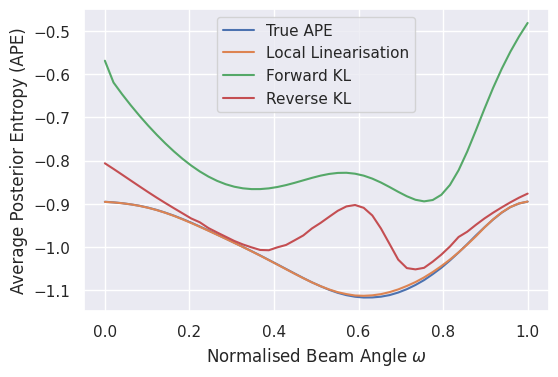

In [17]:
d_vals = jnp.linspace(0,1,50)
with open('computed_ape.json', 'r') as f:
    ape_vals = json.load(f)

fig, ax = plt.subplots()
for i, (key, ape_i) in enumerate(ape_vals.items()):
    sns.lineplot(x=np.array(d_vals).squeeze(), y=np.array(ape_i).squeeze(), color=palette[i], label=key)
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
plt.savefig(os.path.join(fig_save_dir, 'ape_comparison.png'), dpi=mpl_save_dpi)

One may be concerned by the fact that the APE values we've computed are all negative. Indeed, it's a well-known result that the entropy of a discrete random variable is always non-negative. In this case, however, we're dealing with continuous probability distributions. Unlike their discrete counterparts, the entropy of a continuous random variable *can* be negative (proof of this fact can be found [here](https://statproofbook.github.io/P/dent-neg.html)). Indeed, this is why people tend to refer to the entropy of continuous variables as the *differential entropy* instead of just using the term 'entropy'.

# APE Computations with Gradient

We now know what each loss landscape looks like. In more practical situations, however, we don't want to have to compute this. Instead, we'd rather just use a stochastic gradient algorithm - let's try that now.

First, we'll create an ADAM optimiser and define three starting points for the optimisation problem:

In [14]:
adam = oed_toolbox.optim.adam_for_oed_loss(lr=1e-2, max_iter=100)
d_start = [0., 0.5, 1.]
num_samples = 100

Now let's perform stochastic gradient descent using each approximation: 

In [15]:
histories = []
d_best = []
for d_0 in d_start:
    print(f'Now performing APE optimisation starting at d = {d_0:.2f}')
    print(f'Laplace approx...')
    d_laplace, laplace_history = adam(laplace_ape, d_0, num_samples, rng=np.random.default_rng(np_seed), 
                                      return_history=True, verbose=False)
    print(f'Forward approx...')
    d_forward, forward_history = adam(forward_ape, d_0, num_samples, rng=np.random.default_rng(np_seed), 
                                      return_history=True, verbose=False)
    print(f'Reverse approx...')
    d_reverse, reverse_history = adam(reverse_ape, d_0, num_samples, rng=np.random.default_rng(np_seed), 
                                      return_history=True, verbose=False)
    d_best.append({'Local Linearisation': d_laplace, 'Forward KL': d_forward, 'Reverse KL': d_reverse})
    histories.append({'Local Linearisation': laplace_history, 'Forward KL': forward_history, 'Reverse KL': reverse_history})

optim_results = {'d_start': d_start, 'histories': histories, 'd_best': d_best}
with open('ape_optimisation.json', 'w') as f:
    json.dump(Arraytainer(optim_results).tolist(), f, indent=4)

Now performing APE optimisation starting at d = 0.00
Laplace approx...
Forward approx...
Reverse approx...
Now performing APE optimisation starting at d = 0.50
Laplace approx...
Forward approx...
Reverse approx...
Now performing APE optimisation starting at d = 1.00
Laplace approx...
Forward approx...
Reverse approx...


Plots for d_0 = 0.0
Plots for d_0 = 0.5
Plots for d_0 = 1.0


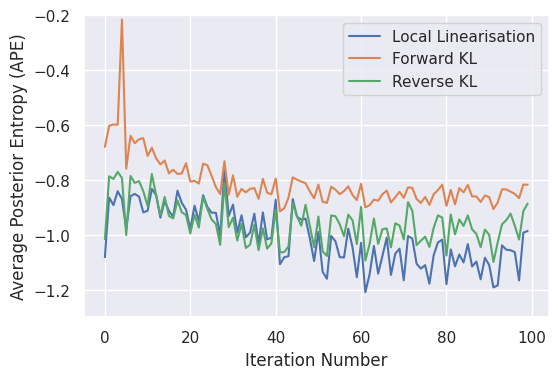

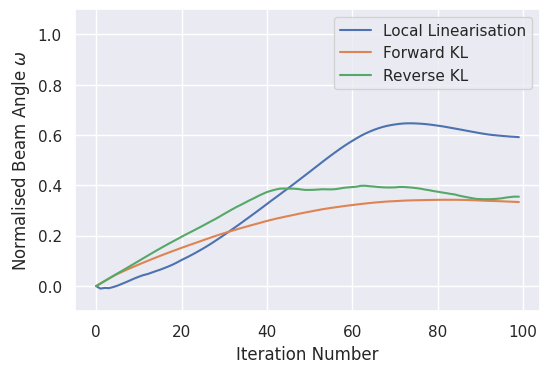

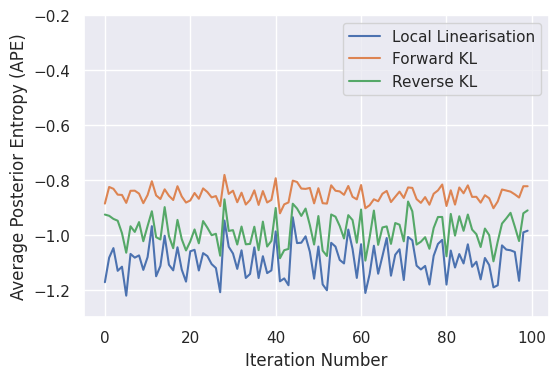

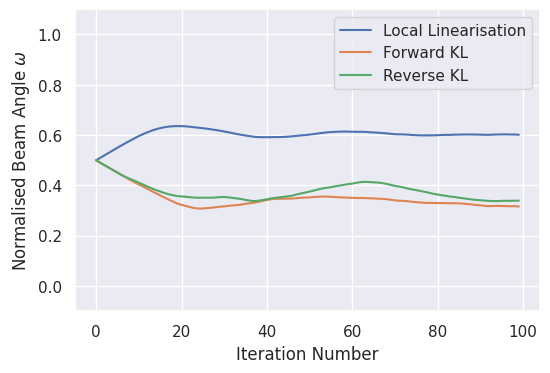

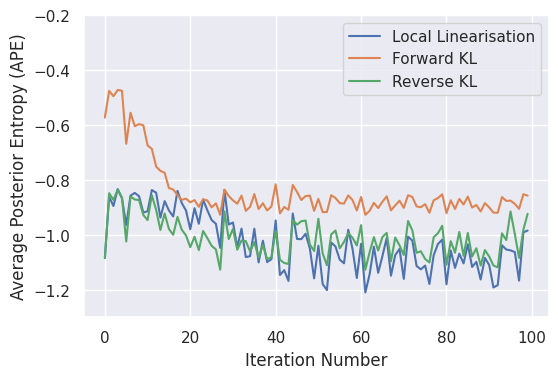

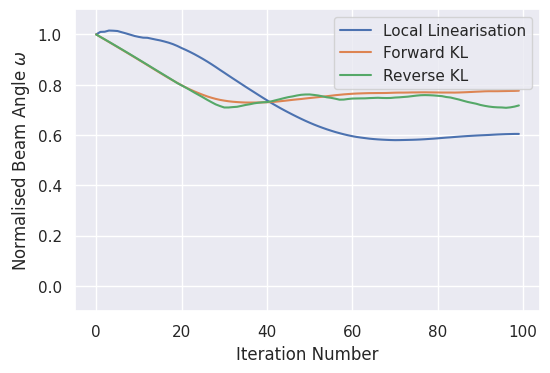

In [16]:
with open('ape_optimisation.json', 'r') as f:
    ape_optimisation = json.load(f)

for d_start, histories in zip(ape_optimisation['d_start'], ape_optimisation['histories']):
    print(f'Plots for d_0 = {d_start}')
    for var_name in ('loss', 'd'):
        fig, ax = plt.subplots()
        for i, (dist_name, dist_history) in enumerate(histories.items()):
            it_num = np.arange(0, len(dist_history[var_name]))
            var_to_plot = np.array(dist_history[var_name]).squeeze()
            sns.lineplot(x=it_num, y=var_to_plot, color=palette[i], label=dist_name)
        ax.set_xlabel('Iteration Number')
        if var_name == 'loss':
            ax.set_ylabel('Average Posterior Entropy (APE)')  
            ax.set_ylim(-1.3, -0.2)
        else: 
            ax.set_ylabel('Normalised Beam Angle $\omega$')
            ax.set_ylim(-0.1, 1.1)
        plt.savefig(os.path.join(fig_save_dir, f'{var_name}_history_d0={d_start:.1f}.png'), dpi=mpl_save_dpi)
        fig.show()

In [27]:
for i, (d_0, hist) in enumerate(zip(optim_results['d_start'], optim_results['histories'])):
    print(f'Optimal designs for d_start = {d_0}:')
    for key, hist_i in hist.items():
        d_end = hist_i['d'][-1]
        print(f'   {key}: {d_end}')

Optimal designs for d_start = 0.0:
   Local Linearisation: 0.5917668968134764
   Forward KL: 0.3337744474411011
   Reverse KL: 0.35519319772720337
Optimal designs for d_start = 0.5:
   Local Linearisation: 0.6011624011254084
   Forward KL: 0.316068559885025
   Reverse KL: 0.3393966555595398
Optimal designs for d_start = 1.0:
   Local Linearisation: 0.6045988068520897
   Forward KL: 0.7763584852218628
   Reverse KL: 0.7177728414535522


It appears from this that around $d = 0.6$ is the optimal design.